# Bagging (Bootstrap aggregation)
The main idea is to reduce the prediction variance by averaging predictions over many bootstrap samples.

Algorithm:

Input: training data $Z={(x_1, y_1), (x_2, y_2), ..., (x_N, y_N)}$

Step 1: Generate $B$ bootstrap samples of $Z$

Step 2: For each sample $Z^{*b}, b=1,2,...,B$, fit a model $\hat{f}^{*b}$

Step 3: Average prediction: $\hat{f}_{bag}(x)=\frac{1}{B}\sum_{b=1}^{B}\hat{f}^{*b}(x)$

Because bagging is used to reduce the prediction variance, it works best on unstable estimators. Highly nonlinear estimators seem to benefit the most from bagging, such as decision trees.

For a regression problem, the bagged estimate is simply the average of all regressors.

For a classification problem, it is slightly more complicated. Majority voting is a solution where the class with the most votes will be chosen. An alternative is to average the predicted probabilities, and this method is said to represent class probabilities quite well with lower variance.

# Example of reduced error

In [ ]:
import numpy as np

p, N = 5, 30
means = np.zeros(shape=(p))
covs = np.diag(np.ones(shape=(p)))
np.place(covs, covs == 0, 0.95)
X = np.random.multivariate_normal(means, covs, N)
X_test = np.random.multivariate_normal(means, covs, 2000)
def f(X):
    return ((X[:,0] <= 0.5)*(np.random.randint(0, 10, X.shape[0]) < 2) + \
           (X[:,0] > 0.5)*(np.random.randint(0, 10, X.shape[0]) >= 2)).astype(int)
Y = f(X)
Y_test = f(X_test)
Y_test_hat = (X_test[:,0]>0.5).astype(int)
bayes_error = np.mean(np.abs(Y_test-Y_test_hat))
print("Bayes error: ", bayes_error)

Bayes error:  0.191


In [ ]:
from sklearn.tree import DecisionTreeClassifier

# original tree
original_clf = DecisionTreeClassifier(max_depth=5)
original_clf.fit(X, Y)
Y_test_hat_tree = original_clf.predict(X_test)
original_tree_error = np.mean(np.abs(Y_test-Y_test_hat_tree))
# bootstrap trees
models = []
for i in range(200):
    samples_idx = np.random.choice(list(range(N)), N)
    X_ = X[samples_idx, :]
    Y_ = Y[samples_idx]
    clf = DecisionTreeClassifier(max_depth=5)
    clf.fit(X_, Y_)
    models.append(clf)

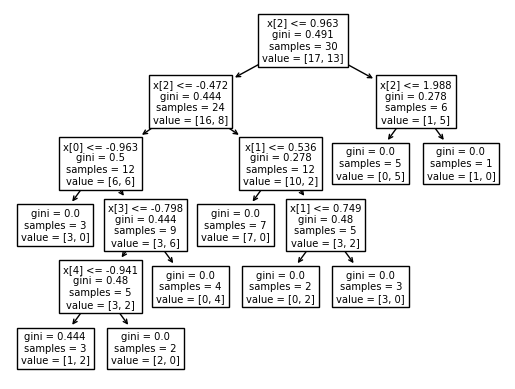

In [ ]:
from sklearn.tree import plot_tree

_ = plot_tree(original_clf)

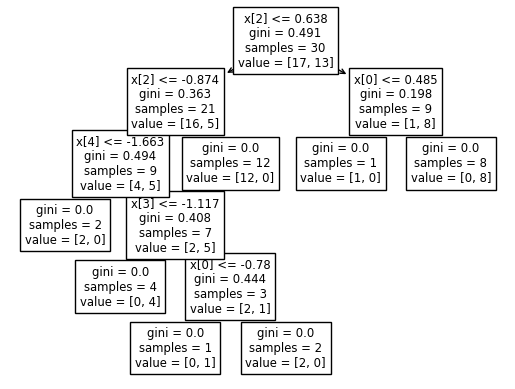

In [ ]:
_ = plot_tree(models[np.random.randint(0, 200, 1)[0]])

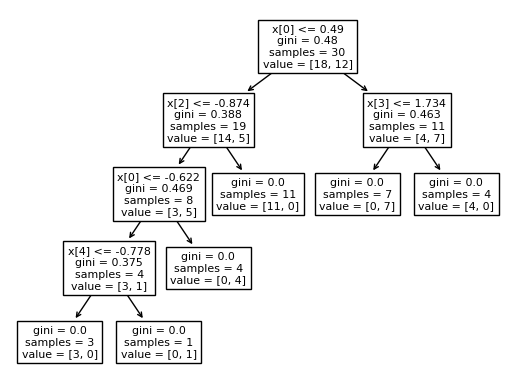

In [ ]:
_ = plot_tree(models[np.random.randint(0, 200, 1)[0]])

In [ ]:
error_concensus = []
error_proba = []
for i in range(1, 200, 10):
    Y_test_hat = np.zeros(shape=(Y_test.shape[0], i))
    Y_test_hat_proba = np.zeros(shape=(Y_test.shape[0], i))
    for k in range(i):
        Y_test_hat[:, k] = models[k].predict(X_test)
        Y_test_hat_proba[:, k] = models[k].predict_proba(X_test)[:,1]
    error_concensus.append(np.mean(np.abs(Y_test - np.round(np.mean(Y_test_hat, axis=1)))))
    error_proba.append(np.mean(np.abs(Y_test - np.round(np.mean(Y_test_hat_proba, axis=1)))))

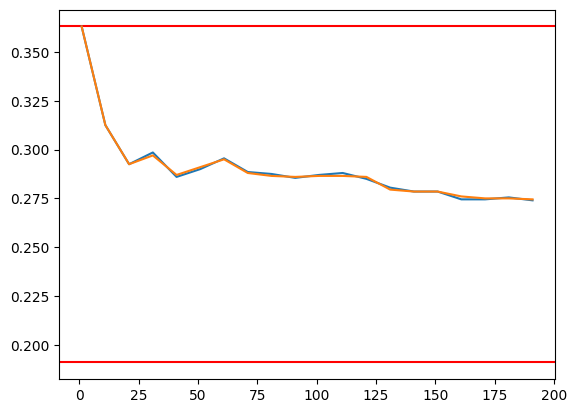

In [ ]:
import matplotlib.pyplot as plt

plt.axhline(y = original_tree_error, color = 'r', linestyle = '-')
plt.axhline(y = bayes_error, color = 'r', linestyle = '-')
plt.plot(range(1,200, 10), error_concensus)
plt.plot(range(1,200, 10), error_proba)

# How can bagging help?

# For regression problem
With a distribution $\mathcal{P}$ of the training data, let $f_{ag}(x)=E_{\mathcal{P}}\hat{f}^*(x)$ be the ideal aggregate estimator.

$\begin{align}
    E_{\mathcal{P}}[Y-\hat{f}^*(x)]^2&=E_{\mathcal{P}}[Y-f_{ag}(x)+f_{ag}(x)-\hat{f}^*(x)]^2\\
    &=E_{\mathcal{P}}[Y-f_{ag}(x)]^2+2E_{\mathcal{P}}[(Y-f_{ag}(x))(f_{ag}(x)-\hat{f}^*(x))]+E_{\mathcal{P}}[f_{ag}(x)-\hat{f}^*(x)]^2\\
    &=E_{\mathcal{P}}[Y-f_{ag}(x)]^2+E_{\mathcal{P}}[f_{ag}(x)-\hat{f}^*(x)]^2\\
    &\geq E_{\mathcal{P}}[Y-f_{ag}(x)]^2
 \end{align}$

 The variance introduced by $\hat{f}^*(x)$ can be reduced by aggregating multiple such $\hat{f}^*(x)$.

# The case for classification
We cannot use the bias-variance decomposition, so we use a consensus of "weak learners".

Suppose we have a binary classification problem with multiple weak learners $G_b^*$ with error rate $e_b=e<0.5$. The consensus vote of these learners is $S_1(x)=\sum_{b=1}^BI(G_b^*(x)=1)$. Then, $S_1(x)\sim Bin(B, 1-e)$ and $P(S_1(x)>B/2)→1$ as $B$ gets large.

However, for this to be actually effective in practice, the learners must be independent. Since they draw from the same training data, they are somewhat correlated. Random forest tackles this issue.

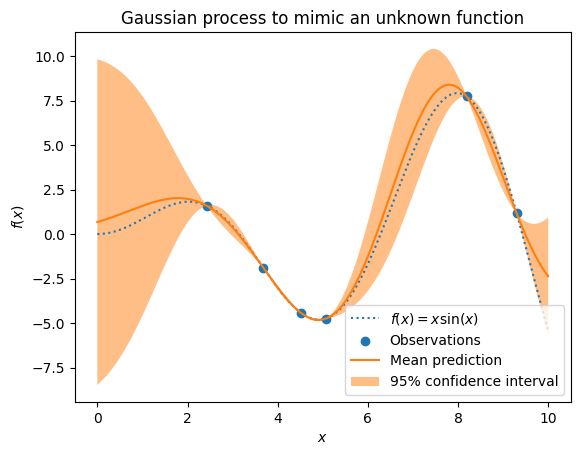

In [8]:
import numpy as np
import matplotlib.pyplot as plt

X = np.linspace(start=0, stop=10, num=1_000).reshape(-1, 1)
y = np.squeeze(X * np.sin(X))

rng = np.random.RandomState(1)
training_indices = rng.choice(np.arange(y.size), size=6, replace=False)
X_train, y_train = X[training_indices], y[training_indices]

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(X_train, y_train)

mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)

plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend(loc="lower right")
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process to mimic an unknown function")